In [1]:
import json

import numpy as np
import pandas as pd
import plotly.express as px
import requests
import seaborn as sns
import statsmodels.api as sm
from matplotlib import pyplot as plt

In [524]:
df_rest = pd.read_csv("./../datasets/enh_restaurants/enh_restaurants.csv.zip", index_col=0)
df_reviews = pd.concat(
    [
        # pd.read_csv("./../datasets/enh_reviews/enh_reviews.csv.zip", index_col=0),
        # pd.read_csv("./../datasets/enh_freviews/enh_freviews.csv.zip", index_col=0)
        pd.read_csv("./../datasets/proc_reviews/proc_reviews.csv.zip", index_col=0),
        pd.read_csv("./../datasets/raw_freviews/raw_freviews.csv.zip", index_col=0)
    ],
    ignore_index=True
)
df_fake_reviews = pd.read_csv("./../datasets/raw_freviews/raw_freviews.csv.zip", index_col=0)
df_real_reviews = pd.read_csv("./../datasets/proc_reviews/proc_reviews.csv.zip", index_col=0)

In [525]:
#changing restaurants

# drop unecessary columns for this analysis
#rename alias
df_rest.rename(columns={'alias': 'rest_alias'}, inplace=True)

# drop unecessary columns for this analysis
df_rest.drop(['id', 'coordinates.latitude', 'coordinates.longitude', 'is_closed',
                      'arrondissement'], axis=1, inplace=True)
df_rest.set_index('rest_alias', inplace=True)

#changing fake reviews

# remove non date type
df_fake_reviews['date'] = pd.to_datetime(df_fake_reviews['date'], format="%d/%m/%Y", errors='coerce')
df_fake_reviews = df_fake_reviews[~df_fake_reviews['date'].isna()]

#remove non number ratings
df_fake_reviews['rating'] = pd.to_numeric(df_fake_reviews['rating'], errors='coerce', downcast = 'integer')
df_fake_reviews = df_fake_reviews[~df_fake_reviews['rating'].isna()]

# drop unecessary columns for this analysis
df_fake_reviews.drop(['user_origin', 'user_friends_count', 'text', 'reviews_have_photos',
                      'has_img', 'user_reviews_count'], axis=1, inplace=True)



#changing real reviews

#remove non date type
df_real_reviews['date'] = pd.to_datetime(df_real_reviews['date'], format="%d/%m/%Y", errors='coerce')
df_real_reviews = df_real_reviews[~df_real_reviews['date'].isna()]

#rename alias
df_real_reviews.rename(columns={'business.alias': 'rest_alias'}, inplace=True)

# drop unecessary columns for this analysis
df_real_reviews.drop(['totalPhotos', 'comment.text', 'comment.language', 'user.reviewCount',
                      'user.displayLocation', 'has_img', 'user.friendCount'], axis=1, inplace=True)


In [526]:
df_review = pd.concat([df_real_reviews,df_fake_reviews])
df_review.head()

,rating,date,is_fake,rest_alias
1,4.0,2013-11-12,False,the-lizard-lounge-paris
5,2.0,2011-02-06,False,the-lizard-lounge-paris
8,3.0,2010-06-02,False,the-lizard-lounge-paris
12,5.0,2018-06-11,False,the-lizard-lounge-paris
15,4.0,2017-04-12,False,the-lizard-lounge-paris


In [527]:
df_rest.head()

,name,review_count,categories,rating,price,freview_count,freview_pct,treview_count
rest_alias,,,,,,,,
the-wok-store-paris,The Wok Store,1,['wok'],3.0,3,1.0,0.500000,2.0
le-wok-saint-germain-paris,Le Wok Saint-Germain,30,"['wok', 'vietnamese', 'thai']",3.5,2,23.0,0.433962,53.0
royal-buffet-paris,Royal Buffet,5,"['japanese', 'chinese', 'wok']",4.0,2,3.0,0.375000,8.0
ô-woking-paris-3,Ô Woking,2,"['wok', 'thai']",4.0,3,1.0,0.333333,3.0
wok-addict-paris,Wok Addict,6,"['wok', 'thai']",3.5,2,0.0,0.000000,6.0


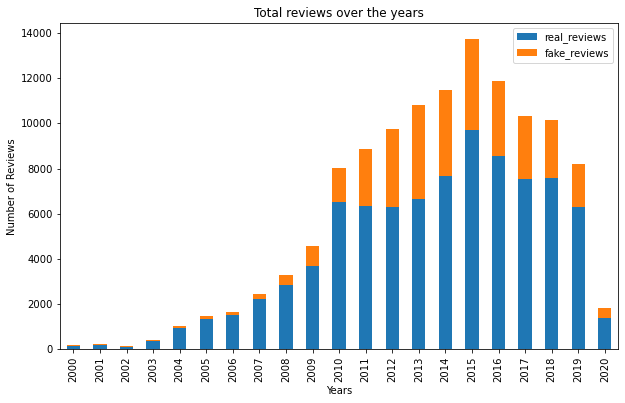

In [528]:
years_reviews = pd.DataFrame()
years_reviews['real_reviews'] = df_real_reviews['rest_alias'].groupby(df_real_reviews['date'].dt.year).count()
years_reviews['fake_reviews'] = df_fake_reviews['rest_alias'].groupby(df_fake_reviews['date'].dt.year).count()


ax = years_reviews.plot.bar(stacked=True, figsize=(10,6),
                              title = "Total reviews over the years",
                              xlabel = "Years", 
                              ylabel = "Number of Reviews")



We can see the number of reviews by year and see how the platform was growing during the times, had their maximum in 2015, and maybe lose a little bit of his importance with the entrance in the market of anothers players like TripAdivisor or Google. We can also see the drowning of reviews in 2020 motivated by the pandemic of Covid-19 afecting a lot the market of restaurants.

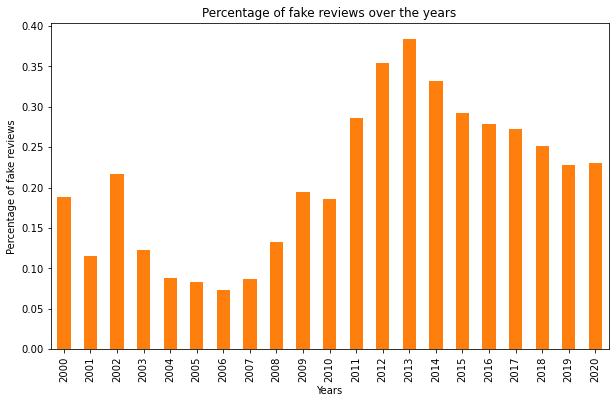

In [443]:
years_reviews['pct'] = years_reviews['fake_reviews']/(years_reviews['real_reviews']+years_reviews['fake_reviews'])
ax = years_reviews['pct'].plot.bar(figsize=(10,6),
                                  title = "Percentage of fake reviews over the years",
                                  xlabel = "Years", 
                                  ylabel = "Percentage of fake reviews",
                                  color = "tab:orange")

As we saw that the number of reviews were growing and being expresive during the 2010 and 2015, the percentage of fake reviews grew too, maybe showing us a tendence of gaming. 

In [Reviews, Reputation, and Revenue: The Case of Yelp.com - Michael Luca] tell us that the rating from of a Seattle restaurant in Yelp could be associated with their revinue. They utilises some data that we don't have for Paris yet, so assuming that is could be also a truth in Paris, this graph can tell us about the possible gaming between the restaurants, showing that at this period, the restaurant noticed the importance of their rating in the platform causing more cheating.

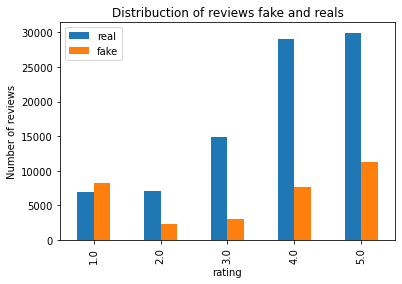

In [505]:
# plt.figure(figsize=(9,6))
# plt.hist(df_fake_reviews['rating'])
# plt.show

count_fake = df_fake_reviews.groupby('rating')['rating'].count()
count_real = df_real_reviews.groupby('rating')['rating'].count()
count = pd.concat([count_real, count_fake], axis=1)
ax = count.plot.bar()

ax.set_ylabel('Number of reviews')
ax.set_title('Distribuction of reviews fake and reals')
ax.legend(['real', 'fake'])

plt.show()

In [555]:
count1 = pd.DataFrame(df_fake_reviews[df_fake_reviews['rating']==1].groupby('rest_alias')['rating'].agg('count'))
count5 = pd.DataFrame(df_fake_reviews[df_fake_reviews['rating']==5].groupby('rest_alias')['rating'].agg('count'))

count1.rename(columns={'rating': 'count1'}, inplace=True)
count5.rename(columns={'rating': 'count5'}, inplace=True)

a = pd.concat([df_rest, count1, count5], axis=1).dropna()
a

,name,review_count,categories,rating,price,freview_count,freview_pct,treview_count,count1,count5
royal-buffet-paris,Royal Buffet,5,"['japanese', 'chinese', 'wok']",4.0,2,3.0,0.375000,8.0,1.0,2.0
waffle-factory-forum-paris-3,Waffle Factory Forum,13,"['hotdogs', 'waffles']",3.0,1,3.0,0.187500,16.0,1.0,1.0
pho-bobun-paris-3,Pho Bobun,36,"['vietnamese', 'thai']",5.0,2,6.0,0.142857,42.0,1.0,5.0
pho-14-opera-paris,Pho 14 Opera,74,"['vietnamese', 'chinese', 'panasian']",4.0,2,3.0,0.038961,77.0,1.0,1.0
pho-2-paris,Pho 2,8,['vietnamese'],2.5,2,2.0,0.200000,10.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...
le-local-rock-paris,Le Local Rock,9,"['bars', 'brasseries']",3.5,2,2.0,0.181818,11.0,1.0,1.0
au-petit-pot-paris-2,Au Petit Pot,5,['bistros'],4.0,2,4.0,0.444444,9.0,2.0,1.0
planet-sushi-saint-mandé,Planet Sushi,5,"['japanese', 'sushi']",3.0,4,4.0,0.444444,9.0,1.0,3.0
matsu-paris-2,Matsu,6,['japanese'],2.5,4,3.0,0.333333,9.0,1.0,2.0


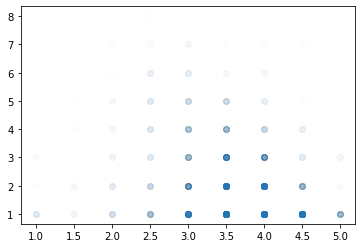

In [566]:
plt.scatter(a['rating'],a['count1'], alpha=0.01)

In [558]:
y = a['count1']

constant = np.ones(len(y))
X = np.column_stack((constant, 
                     a['rating']))

competition_model = sm.OLS(y,X)
competition_model_results = competition_model.fit()
print(competition_model_results.summary())

                            OLS Regression Results                            
Dep. Variable:                 count1   R-squared:                       0.075
Model:                            OLS   Adj. R-squared:                  0.074
Method:                 Least Squares   F-statistic:                     158.2
Date:                Sun, 17 Jan 2021   Prob (F-statistic):           6.05e-35
Time:                        19:42:41   Log-Likelihood:                -3069.5
No. Observations:                1955   AIC:                             6143.
Df Residuals:                    1953   BIC:                             6154.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.6623      0.149     24.622      0.0

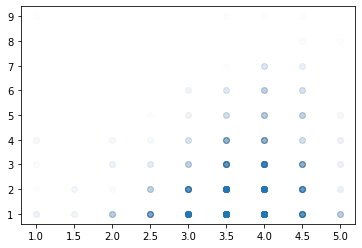

In [567]:
plt.scatter(a['rating'],a['count5'], alpha=0.01)

In [560]:
y = a['count5']

constant = np.ones(len(y))
X = np.column_stack((constant, 
                     a['rating']))

competition_model = sm.OLS(y,X)
competition_model_results = competition_model.fit()
print(competition_model_results.summary())

                            OLS Regression Results                            
Dep. Variable:                 count5   R-squared:                       0.032
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     64.24
Date:                Sun, 17 Jan 2021   Prob (F-statistic):           1.87e-15
Time:                        19:42:43   Log-Likelihood:                -3438.4
No. Observations:                1955   AIC:                             6881.
Df Residuals:                    1953   BIC:                             6892.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7267      0.180      4.046      0.0

In [400]:
def mean_at_the_time(df):
    a = []
    for i in range(df.shape[0]):

        date = df.loc[i][1]
        alias = df.loc[i][3]
        stats = df[(df['date']<date) & (df['rest_alias']==alias) & (df['is_fake']==False)]['rating'].agg(['mean', 'std', 'count'])
        a.append(stats)
        if i%1000 == 0:
            print ('{}%'.format(i*100/df.shape[0]))
    return a

In [401]:
avg_at_time = pd.DataFrame(mean_at_the_time(df))
avg_at_time['index'] = range(avg_at_time.shape[0])
avg_at_time.set_index('index', inplace=True)
avg_at_time


0.0%
0.8305302935924588%
1.6610605871849176%
2.4915908807773763%
3.322121174369835%
4.152651467962294%
4.983181761554753%
5.813712055147212%
6.64424234873967%
7.4747726423321295%
8.305302935924589%
9.135833229517047%
9.966363523109505%
10.796893816701964%
11.627424110294424%
12.457954403886882%
13.28848469747934%
14.119014991071799%
14.949545284664259%
15.780075578256717%
16.610605871849177%
17.441136165441634%
18.271666459034094%
19.10219675262655%
19.93272704621901%
20.76325733981147%
21.593787633403927%
22.424317926996387%
23.254848220588848%
24.085378514181304%
24.915908807773764%
25.74643910136622%
26.57696939495868%
27.40749968855114%
28.238029982143598%
29.068560275736058%
29.899090569328518%
30.729620862920974%
31.560151156513435%
32.390681450105895%
33.221211743698355%
34.05174203729081%
34.88227233088327%
35.71280262447573%
36.54333291806819%
37.37386321166065%
38.2043935052531%
39.03492379884556%
39.86545409243802%
40.69598438603048%
41.52651467962294%
42.357044973215395%
43

,mean,std,count
index,,,
0,3.775000,0.767530,40.0
1,3.800000,0.761124,30.0
2,3.800000,0.763763,25.0
3,3.767857,0.808839,56.0
4,3.773585,0.823723,53.0
...,...,...,...
120400,NaN,NaN,0.0
120401,NaN,NaN,0.0
120402,2.000000,NaN,1.0


In [409]:
df = df_review[:]
df['index'] = range(df.shape[0])
df = df.set_index('index')
df = pd.concat([df, avg_at_time], axis=1)
df.dropna(inplace=True)
df

<ipython-input-409-ce749bb85ade>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['index'] = range(df.shape[0])


,rating,date,is_fake,rest_alias,mean,std,count
index,,,,,,,
0,4.0,2013-11-12,False,the-lizard-lounge-paris,3.775000,0.767530,40.0
1,2.0,2011-02-06,False,the-lizard-lounge-paris,3.800000,0.761124,30.0
2,3.0,2010-06-02,False,the-lizard-lounge-paris,3.800000,0.763763,25.0
3,5.0,2018-06-11,False,the-lizard-lounge-paris,3.767857,0.808839,56.0
4,4.0,2017-04-12,False,the-lizard-lounge-paris,3.773585,0.823723,53.0
...,...,...,...,...,...,...,...
120393,5.0,2014-08-14,True,la-banquette-vincennes,4.666667,0.577350,3.0
120396,4.0,2016-09-16,True,birdies-café-montreuil-2,3.333333,0.577350,3.0
120397,4.0,2016-09-26,True,danieli-caffè-vincennes-3,4.500000,0.707107,2.0


In [437]:
def distance(row):
    if row['std']==0:
        return  pd.NA
    
    else:
        return (row['rating'] - row['mean'])/(row['std'])
    
df['distance_stat'] = df.apply(lambda row: distance(row) , axis=1).dropna()
df[df['is_fake']==True]['distance_stat'].agg(['mean', 'std'])


mean   -0.557769
std     1.805009
Name: distance_stat, dtype: float64

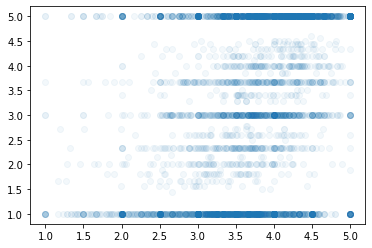

In [451]:
diff = df[((df['rating']==5) | (df['rating']==1)) & (df['is_fake']==True)]
avg = diff.groupby('rest_alias').mean()
avg
plt.scatter(avg['mean'], avg['rating'], alpha=0.05)
# plt.scatter(diff['avg_at_time'], diff['rating'], alpha=0.002)